In [0]:
## Seminar Paper by Kai Ostrowski, 1813268
# Credit-Scoring

In [0]:
#importing packages
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Credit Scoring

## Objectives

- To determine whether or not a loan should be granted, predict whether or not somebody will experience financial distress in the next two years or not.

## Algorithms/Models

- Logistic Regression (Classification)
- Support Vector Machine (Classification)
- Random Forest (Classifcation)

## Data Preview

## Data Dictionary

- SeriousDlqin2yrs = Person experienced 90 days past due delinquency or worse *(TARGET)*
- RevolvingUtilizationOfUnsecuredLines = Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits
- age = Age of borrower in years
- NumberOfTime30-59DaysPastDueNotWorse = Number of times borrower has been 30-59 days past due but no worse in the last 2 years.
- DebtRatio = Monthly debt payments, alimony,living costs divided by monthy gross income
- MonthlyIncome = Monthly income
- NumberOfOpenCreditLinesAndLoans = Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
- NumberOfTimes90DaysLate = Number of times borrower has been 90 days or more past due.
- NumberRealEstateLoansOrLines = Number of mortgage and real estate loans including home equity lines of credit
- NumberOfTime60-89DaysPastDueNotWorse = Number of times borrower has been 60-89 days past due but no worse in the last 2 years.
- NumberOfDependents = Number of dependents in family excluding themselves (spouse, children etc.)

## Basic Literature

- Bellotti, T., & Crook, J. (2009). Support vector machines for credit scoring and discovery of significant features. *Expert Systems with Applications, 36(2)*, 3302-3308. https://doi.org/10.1016/j.eswa.2008.01.005.
- Huang, C.-L. et al. (2007). Credit scoring with a data mining approach based on support vector machines. *Expert Systems with Applications, 33(4)*, 847-856. https://doi.org/10.1016/j.eswa.2006.07.007.
- Thomas, L. et al. (2017). *Credit Scoring and Its Applications*. Philadelphia, PA: Society for Industrial and Applied Mathematics. 

## Source

https://www.kaggle.com/c/GiveMeSomeCredit

In [0]:
url = "https://raw.githubusercontent.com/lpostri/ostri2/master/credit_scoring.csv"
df = pd.read_csv(url).drop('Unnamed: 0', axis = 1)
df.head()

cleanCol = []
for i in range(len(df.columns)):
    cleanCol.append(df.columns[i].replace('-', '_'))
    
df.columns = cleanCol



In [0]:
df.describe()

In [0]:
df.info()

In [0]:
#Count of Target Variable
print(df["SeriousDlqin2yrs"].value_counts())

In [0]:
#figure 1: distribution of target variable
##execute this code cell two times to avoid grey image borders . Had this issue with Google Colab
ax = sns.countplot(x = df.SeriousDlqin2yrs ,palette="Set1")
sns.set(font_scale=1.5)
ax.set_ylim(top = 150000)
ax.set_xlabel('Financial difficulty in 2 years')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=160000)



In [0]:
#shows us the number of missing values in each column
null_counts = df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

In [0]:
##MISSING VALUES
#figure 2 : Missing Values in Dataset
ls,names=[],[]
for i,col in enumerate(df.columns):
  if df[col].isnull().sum() != 0:
    ls.append(df[col].isnull().sum())
    names.append(col)
pd.DataFrame({'Nulls':ls},index=names).plot.barh(color='orange',edgecolor='yellow')

In [0]:
#Missing values before outliers : random forest not sensitive to outliers
#filling Number Of Dependents with 0
df.NumberOfDependents = df.NumberOfDependents.fillna(0)

In [0]:
#creating a copy for random forest imputation
df2 = df.iloc[:, [5, 0, 1, 2, 3, 4, 6, 7, 8, 9]]
df2.describe()

In [0]:
#split into two datasets, one with NAs and one without
known = df2.loc[df.MonthlyIncome.notnull(), :]
unknown = df2.loc[df.MonthlyIncome.isnull(), :]

In [0]:
#create X and y for random forest
X = known.iloc[:, 1:]
y = known.iloc[:, 0]

In [0]:
#random forest regressor
model_imputation = RandomForestRegressor(random_state=0, n_estimators=200,
                              max_depth=3, n_jobs=-1)
model_imputation.fit(X, y)

In [0]:
#predict values for NAs with help of Random Firest and round them without digits
pred = model_imputation.predict(unknown.iloc[:, 1:]).round(0)

In [0]:
#substitute Pred with the missing values in MonthlyIncome
df.loc[(df.MonthlyIncome.isnull()), 'MonthlyIncome'] = pred

In [0]:
##DATA EXPLORATION

In [0]:
#age
#Figure 4: Boxplot of Age
sns.boxplot(x = df["age"])

In [0]:
#age
#figure 3: Default vs Non-Default with age
age_hist = df['age'].hist(by=df['SeriousDlqin2yrs'], bins=20, layout=(2,1), figsize=(7,5))
age_hist[0].set_xlim((0,100))
age_hist[0].set_title('SeriousDlqin2yrs = 0')
age_hist[1].set_xlim((0,100))
age_hist[1].set_title('SeriousDlqin2yrs = 1')

In [0]:
#remove age outlier and replace it with value "21"
ageNew = []
for val in df.age:
    if val > 20:
        ageNew.append(val)
    else:
        ageNew.append(21)
        
df.age = ageNew

In [0]:
#NumberOfTimes90DaysLate
#Figure 5: Counter of NumberOfTimes90DaysLate
Counter(df.NumberOfTimes90DaysLate)

In [0]:
#NumberOfTime30_59DaysPastDueNotWorse Count
Counter(df.NumberOfTime30_59DaysPastDueNotWorse)

In [0]:
#NumberOfTime60_89DaysPastDueNotWorse Count
Counter(df.NumberOfTime60_89DaysPastDueNotWorse)

In [0]:
#Remove 98s and 96s from df
df= df.drop(df[df['NumberOfTimes90DaysLate'] > 20].index)
df= df.drop(df[df['NumberOfTime30_59DaysPastDueNotWorse'] > 20].index)
df= df.drop(df[df['NumberOfTime60_89DaysPastDueNotWorse'] > 20].index)

In [0]:
#RevolvingUtilizationOfUnsecuredLines 
df.RevolvingUtilizationOfUnsecuredLines.quantile([.975])

In [0]:
#RevolvingUtilizationOfUnsecuredLines maximum value
np.amax(df["RevolvingUtilizationOfUnsecuredLines"])

In [0]:
#RevolvingUtilizationOfUnsecuredLines over and equal 1 respect to target
df[(df["RevolvingUtilizationOfUnsecuredLines"] >= 1) ].SeriousDlqin2yrs.describe()

In [0]:
#RevolvingUtilizationOfUnsecuredLines between values 1 and 5, respect to target
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 1) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 5)].SeriousDlqin2yrs.describe()

In [0]:
#RevolvingUtilizationOfUnsecuredLines between values 5 and 10, respect to target
df[(df['RevolvingUtilizationOfUnsecuredLines'] > 5) & (df['RevolvingUtilizationOfUnsecuredLines'] <= 10)].SeriousDlqin2yrs.describe()

In [0]:
#RevolvingUtilizationOfUnsecuredLines over values of 10, respect to target
#Mean of Target approximatily equals to Mean of sample or values over 10
df[(df["RevolvingUtilizationOfUnsecuredLines"] >= 10) ].SeriousDlqin2yrs.describe()

In [0]:
#dropping values over 10 from df
df= df.drop(df[df['RevolvingUtilizationOfUnsecuredLines'] > 10].index)

In [0]:
#DebtRatio
df.DebtRatio.quantile(0.975)

In [0]:
#DebtRatio over 3489 respect to Target
df[(df['DebtRatio'] >= 3489) ].SeriousDlqin2yrs.describe()

In [0]:
#dropping values over 3489 from df
df= df.drop(df[df['DebtRatio'] > 3489.025].index)

In [0]:
##transformation of variables for Figure 6 : Correlation Matrix
df_renamed = df.rename(columns={
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30_59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60_89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

In [0]:
#Figure 6: Correlation Matrix 
cor=df_renamed.corr()
fig, ax = plt.subplots(figsize=(11,11))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,fmt = ".2f",annot=True,ax=ax)

In [0]:
##Creating new variable named DefaultedCombinedDays
df["DefaultedCombinedDays"] = (df["NumberOfTimes90DaysLate"] + df["NumberOfTime60_89DaysPastDueNotWorse"])\
                                        + df["NumberOfTime30_59DaysPastDueNotWorse"]

In [0]:
##transform it in 0 and 1
df.loc[(df["DefaultedCombinedDays"] >= 1), "DefaultedCombinedDays"] = 1

In [0]:
#Figure 7: Value Counts of new feature
df.DefaultedCombinedDays.value_counts()

In [0]:
#info after preprocessing
df.info()

In [0]:
#determine X any determine y
X, y = df.drop(["SeriousDlqin2yrs","NumberOfTime60_89DaysPastDueNotWorse","NumberOfTime30_59DaysPastDueNotWorse"], axis=1), df["SeriousDlqin2yrs"]

In [0]:
##LOGISTIC REGRESSION MODEL
#hyperparameters
hyperparams = {'loss': 'log', 'penalty': "l1", 'alpha': 0.0001, 'max_iter': 500, 
               'tol': 1e-3, 'random_state': 1909, 'eta0': 0.01}



model = SGDClassifier(**hyperparams)
model = model.fit(X, y)



In [0]:
#split data into Train and Test Set
#Standardize features by removing the mean and scaling to unit variance
#fit <- Compute the mean and std to be used for later scaling.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1909)

scaler = StandardScaler().fit(X_train)

In [0]:
#Perform standardization by centering and scaling
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [0]:
#fit model
model.fit(X_train_scaled, y_train)
logit_scores_proba = model.predict_proba(X_train_scaled)
logit_scores = logit_scores_proba[:,1]

In [0]:
#ROC curve function
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

In [0]:
#Figure 8: ROC Curve logistic model
fpr_logit, tpr_logit, thresh_logit = roc_curve(y_train, logit_scores)
plot_roc_curve(fpr_logit,tpr_logit)
print("AUC Score {}".format(roc_auc_score(y_train,logit_scores)))

In [0]:
#Validation ROC Curve with X_Test (Appendix)
logit_scores_proba_val = model.predict_proba(X_test_scaled)
logit_scores_val = logit_scores_proba_val[:,1]
fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(y_test, logit_scores_val)
plot_roc_curve(fpr_logit_val,tpr_logit_val)
print("AUC Score {}".format(roc_auc_score(y_test,logit_scores_val)))

In [0]:
##Hyperparameter Tuning GRIDSEARCH with predefined hyperparameters for n_estimators and max_depth for RANDOM FOREST
n_estimators = [10, 100, 200, 300]
max_depth = [3,5]
param_grid = {'n_estimators': n_estimators,  'max_depth': max_depth}

In [0]:
##random forest model
# Hyperparameter Definitions
hyperparams = {
    'n_estimators': 300, 'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2, 
    'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features':5, 
    'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 
    'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': 1909, 
    'verbose': 0, 'warm_start': False, 'class_weight': "balanced"}

# Model Reinitialization
model2 = RandomForestClassifier(**hyperparams)
model2 = model2.fit(X,y)

In [0]:
#grid search 

gs = GridSearchCV(model2, param_grid=param_grid, scoring="roc_auc", n_jobs=-1, iid=False, cv=4)
gs = gs.fit(X, y)

print(f'Optimal parameters: {gs.best_params_}')

AUC Score 0.8620607836637759


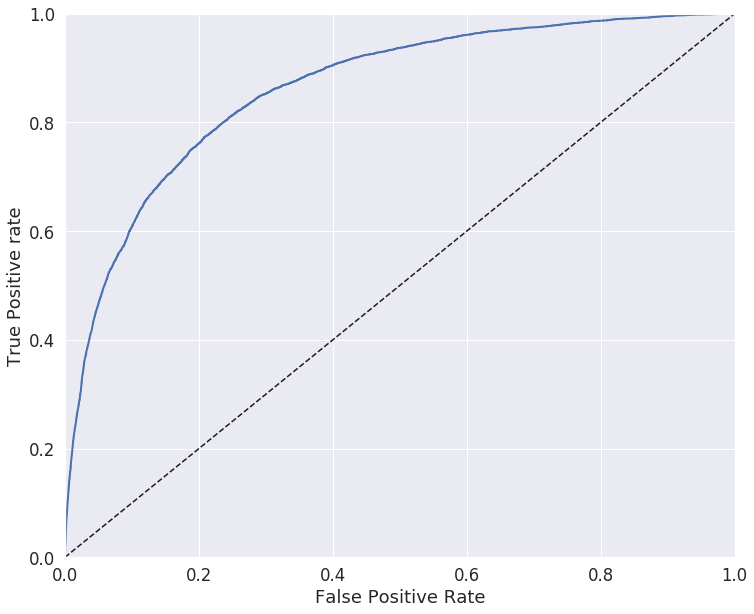

In [0]:
#Figure 9: ROC Curve Random Forest
model2.fit(X_train,y_train) #Using the original dataset, not the resampled
y_scores_proba = model2.predict_proba(X_train)
y_scores = y_scores_proba[:,1]
fpr, tpr, thresh = roc_curve(y_train, y_scores)
plot_roc_curve(fpr,tpr)
print("AUC Score {}".format(roc_auc_score(y_train,y_scores))) #max_depth=5 .8525 #7 .864 cross .85 #10 .89 cross .85 #9 .88 cross .853 #12 .92 cross .84 Overfit!

AUC Score 0.8534670585707381


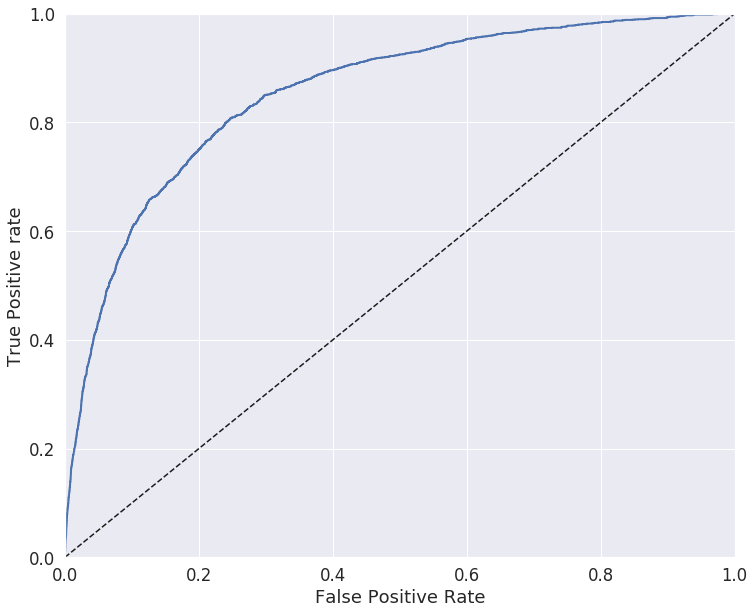

In [0]:
#ROC Curve validation
y_val_proba = model2.predict_proba(X_test)
y_scores_val = y_val_proba[:,1]
fpr_val, tpr_val, thresh_val = roc_curve(y_test, y_scores_val)
plot_roc_curve(fpr_val,tpr_val)
print("AUC Score {}".format(roc_auc_score(y_test,y_scores_val)))

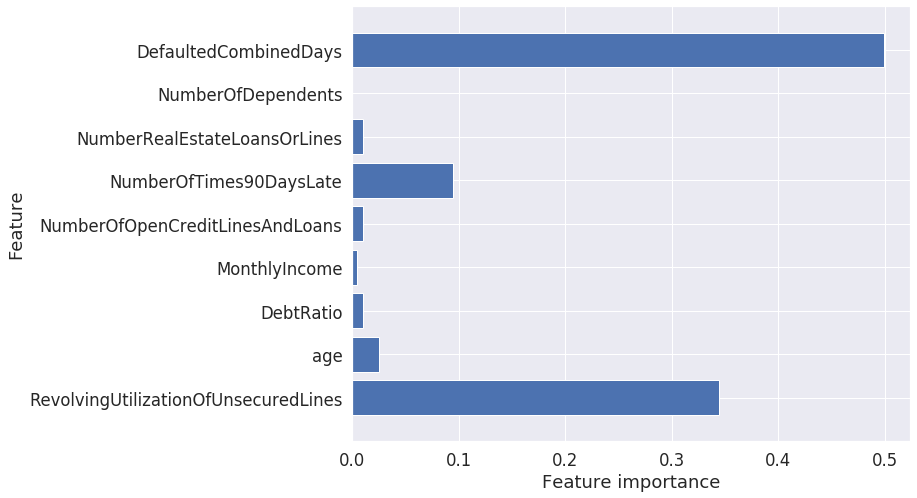

In [0]:
#Figure 10: Feature Importance Random Forest
def plot_feature_importances(model):
    plt.figure(figsize=(10,8))
    n_features = X.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), X.columns)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(model2)

In [0]:
scoring = ['accuracy', 'recall', 'precision', 'f1']
res_cv = cross_validate(model2, X, y, scoring=scoring, cv=4, return_train_score=True)

res_acc_tr = np.mean(res_cv['train_accuracy']) * 100
res_acc_te = np.mean(res_cv['test_accuracy']) * 100
print(f'Average Accurarcy on Training and Test Set: {res_acc_tr:.2f}%/{res_acc_te:.2f}%')

res_rec_tr = np.mean(res_cv['train_recall']) * 100
res_rec_te = np.mean(res_cv['test_recall']) * 100
print(f'Average Recall on Training and Test Set: {res_rec_tr:.2f}%/{res_rec_te:.2f}%')


# Precision Output for Training and Test Set
res_prec_tr = np.mean(res_cv['train_precision']) * 100
res_prec_te = np.mean(res_cv['test_precision']) * 100
print(f'Average Precision on Training and Test Set: {res_prec_tr:.2f}%/{res_prec_te:.2f}%')


# F1 Output for Training and Test Set
res_f1_tr = np.mean(res_cv['train_f1']) * 100
res_f1_te = np.mean(res_cv['test_f1']) * 100
print(f'Average F1 on Training and Test Set: {res_f1_tr:.2f}%/{res_f1_te:.2f}%')

Average Accurarcy on Training and Test Set: 76.22%/76.09%
Average Recall on Training and Test Set: 80.15%/79.19%
Average Precision on Training and Test Set: 19.07%/18.85%
Average F1 on Training and Test Set: 30.80%/30.44%


In [0]:
#Gradient Boosting Tree
gbc_clf_submission = GradientBoostingClassifier(n_estimators=250, learning_rate=0.05 ,max_depth=6,  random_state=42)
gbc_clf_submission.fit(X_train,y_train)
gbc_clf_proba = gbc_clf_submission.predict_proba(X_train)
gbc_clf_scores = gbc_clf_proba[:,1]
gbc_val_proba = gbc_clf_submission.predict_proba(X_test)
gbc_val_scores = gbc_val_proba[:,1]
fpr_gbc, tpr_gbc, thresh_gbc = roc_curve(y_train, gbc_clf_scores)
print("AUC Score {}".format(roc_auc_score(y_train, gbc_clf_scores))), print("AUC Score {}".format(roc_auc_score(y_test, gbc_val_scores)))


AUC Score 0.8925244971511993
AUC Score 0.8567147491869992


(None, None)

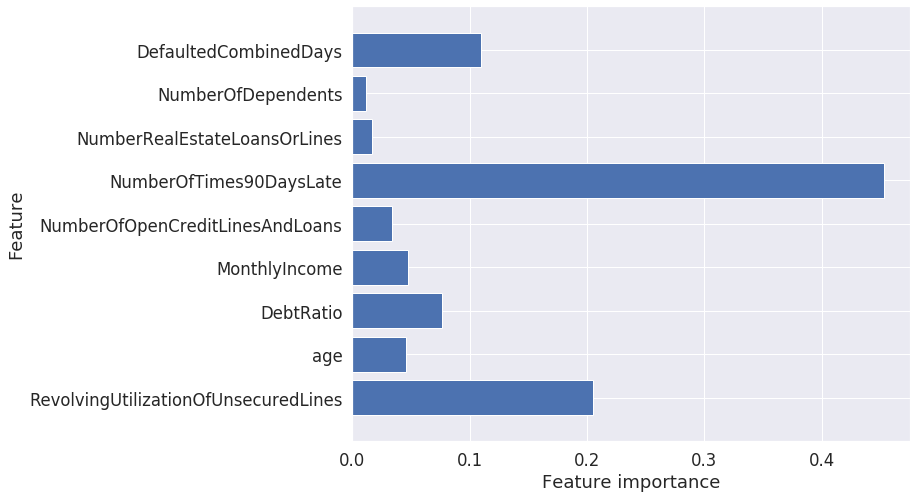

In [0]:
#feature importance Gradient Boosting Tree
plot_feature_importances(gbc_clf_submission)